In [1]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.stats import norm
import math
import seaborn as sns
from scipy.stats import linregress
import scipy.stats as stats
import statsmodels.api as sm
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

## Functions

### cohen_d

The function, cohen_d, calculates the cohen's d between two lists of values. In this context, we are comparing two z-score normalized features. 

The input: 

    group1, group2: List of values to represent the two groups by their features
    
In this function, we calculate the mean of the groups, then calculate a pooled standard deviation (this requires the sample sizes of group1 and 2). Finally, we calculate the cohen's d, (d), which is the output of the function. 

In [4]:
def cohen_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    d = (mean1 - mean2) / pooled_std
    return d

### Applycohen

The function, applycohen, uses the cohen's d function above, to do all the pairwise comparisons requested for a given dataframe.

The input: 

    df: The dataframe to use for the cohen's d comparison (ie. filtering for insertions/ deletions)
    strategy: The label strategy applied. Options: "HomoBasedLabel" or "ClusterBasedLabel"
    
This function, takes the dataframe and calculates the cohen's d across the relevant pairwise comparisons. The output of this function is a wide dataframe which holds the absolute cohen's d. 

To better understand which type of features are most discriminatory, we additionally added "FeatureCat", groups specific features together (this is based on the features' name). The specific groupings are defined in the dictionary, feat_conditions. 

    An example could be "SeqFeat" which groups together SV and flanking GC content, complexity, flexibility and stability

In [129]:
feat_conditions = {
    'SeqFeat': ['gc', 'comp_', 'flex', 'stab'],
    'RepeatMasker': ['LINE', 'Low_complexity', 'LTR', 'Satellite', 'Simple_repeat', 'SINE'],
    'nonBDNA': ['Arep_', 'DR_', 'G4_', 'MR_', 'STR_', 'ZDNA_'],
    'Epigenetics': ['avgepi', 'stdepi', '2000'],
    'DNAShape': ['MGW', 'HelT', 'ProT', 'Roll', 'EP'],
    'ReplicationTiming': ['S50'],
    'Homology': ['pident', 'Blastcoverage'],
    'n': []
}

In [35]:
def applycohen (df, strategy):
    fullfeat = []
    feat = []
    
    # A comparison between the homology-based labels
    if strategy == 'HomoBasedLabel':
        cohens = {'HLH_ILH': [], 'HLH_NLH': [], 'ILH_NLH': [], 'HLH_Undef': [], 'NLH_Undef': []}

    # We want to iterate through all the z-score normalized columns and add it to our fullfeat list
        for i in list(df.filter(regex='zscore').columns):
            fullfeat.append(i)

            # Based on the feat_conditions dictionary, we can assign the feature's class
            feat_cat = 'n'
            for category, keywords in feat_conditions.items():
                if any(keyword in i for keyword in keywords):
                    feat_cat = category
                    break
            feat.append(feat_cat)

            # We have all the unique mechanisms, where by mech_pairs, is a tuple that holds the pairwise comparisons were doing
            mechanisms = ['HLH', 'ILH', 'NLH', 'Undefined']
            mech_pairs = [
                ('HLH', 'ILH', 'HLH_ILH'),
                ('HLH', 'NLH', 'HLH_NLH'),
                ('ILH', 'NLH', 'ILH_NLH'),
                ('HLH', 'Undefined', 'HLH_Undef'),
                ('NLH', 'Undefined', 'NLH_Undef')
            ]

            # We loop through the pairs, whereby the mechanism is pulled out to create 'group1' and 'group2'
            # These lists are sent to the cohen_d function, whereby we keep the absolute cohen's d (magnitude)
            for mech1, mech2, cohens_key in mech_pairs:
                group1 = df[(df.HomoBasedLabel == mech1)][i]
                group2 = df[(df.HomoBasedLabel == mech2)][i]
                cohen_value = np.abs(cohen_d(list(group1), list(group2)))
                cohens[cohens_key].append(cohen_value)

        # Finally, we save the dataframe which holds the lists of cohen's d calculated
        output = pd.DataFrame({
            'FeatureName': fullfeat,
            'FeatureCat': feat,
            'HLH vs ILH': cohens['HLH_ILH'],
            'HLH vs NLH': cohens['HLH_NLH'],
            'ILH vs NLH': cohens['ILH_NLH'],
            'HLH vs Undefined': cohens['HLH_Undef'],
            'NLH vs Undefined': cohens['NLH_Undef'],
        })
        
        
    # The above code is essentially copied and made appropriate for cluster-based comparisons
    elif strategy == 'ClusterBasedLabel':
        cohens = {'clusterI_clusterII': []}

        for i in list(df.filter(regex='zscore').columns):
            fullfeat.append(i)

            feat_cat = 'n'
            for category, keywords in feat_conditions.items():
                if any(keyword in i for keyword in keywords):
                    feat_cat = category
                    break
            feat.append(feat_cat)

            # Change to the pairwise comparisons were trying to do
            mechanisms = ['clusterI', 'clusterII']
            mech_pairs = [
                ('clusterI', 'clusterII', 'clusterI_clusterII'),
            ]

            for mech1, mech2, cohens_key in mech_pairs:
                group1 = df[(df.ClusterBasedLabel == mech1)][i]
                group2 = df[(df.ClusterBasedLabel == mech2)][i]
                cohen_value = np.abs(cohen_d(list(group1), list(group2)))
                cohens[cohens_key].append(cohen_value)

        output = pd.DataFrame({
            'FeatureName': fullfeat,
            'FeatureCat': feat,
            'clusterI vs clusterII': cohens['clusterI_clusterII'],
        })

    
    return output

## Data input

For this, we are using the data from HGSVC2. This is the data after adding homology-based and clustering-based labels 

In [2]:
path = '/Users/nadejdaboev/Desktop/Sushant/HGSVC2/clustering_240821/' # use your path
all_files = glob.glob(os.path.join(path , "chr*.tsv"))
li1 = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, sep='\t')
    chromo = filename.split('240821/')[1].split('.')[0]
    svtype = filename.split('240821/')[1].split('.')[1].split('_')[0]
    df['chromo'] = chromo
    df['svtype'] = svtype
    df['dataset'] = 'HGSV2'

    li1.append(df)
big_hgsvc = pd.concat(li1, axis=0, ignore_index=True)

In [3]:
# !!!! Will need to delete in github verion!!
for idx, row in big_hgsvc.iterrows():
    if row.svtype == 'deletion':
        if row.fuzzypred == 'fuzzy0':
            big_hgsvc.loc[idx, 'fuzzypred'] = 'fuzzy1'
        else:
            big_hgsvc.loc[idx, 'fuzzypred'] = 'fuzzy0'

In [13]:
# !!!! Will need to delete in github verion!!

homo = {
    'NHEJ': 'NLH',
    'SSAaEJ': 'ILH',
    'HR': 'HLH',
    'Undefined': 'Undefined'
}

big_hgsvc['HomoBasedLabel'] = big_hgsvc['mechID_homo'].map(homo)

homo = {
    'fuzzy0': 'clusterI',
    'fuzzy1': 'clusterII',
}

big_hgsvc['ClusterBasedLabel'] = big_hgsvc['fuzzypred'].map(homo)


## Calculating cohen's

We want to calculate effect sizes separately for insertions/ deletions. We then, want to change the wide arrangement to a long arrangement, allowing for merging between the homology-based and clustering-based dataframes. 

### For deletions

In [39]:
homo_wide_del = applycohen(big_hgsvc[(big_hgsvc.svtype == 'deletion')], 'HomoBasedLabel')

homo_long_del = pd.melt(homo_wide_del, id_vars=['FeatureName', 'FeatureCat'], 
                     value_vars=['HLH vs ILH', 'HLH vs NLH', 'ILH vs NLH', 'HLH vs Undefined', 'NLH vs Undefined'], 
                     var_name='cohen_type', 
                     value_name='value')


/Users/nadejdaboev/opt/anaconda3/envs/blahlol/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


#### Visualization

For transparency, I added the steps we used to visualize these features. The dataframe above can be used to regenerate plots in main text

In [107]:
color_scheme=dict(
    Epigenetics='maroon',
    ReplicationTiming='darkkhaki',
    nonBDNA='purple',
    RepeatMasker='dimgray',
    SeqFeat='darkgreen',
    DNAShape='midnightblue', 
    Homology='lime'
)

/Users/nadejdaboev/opt/anaconda3/envs/blahlol/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
/Users/nadejdaboev/opt/anaconda3/envs/blahlol/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.


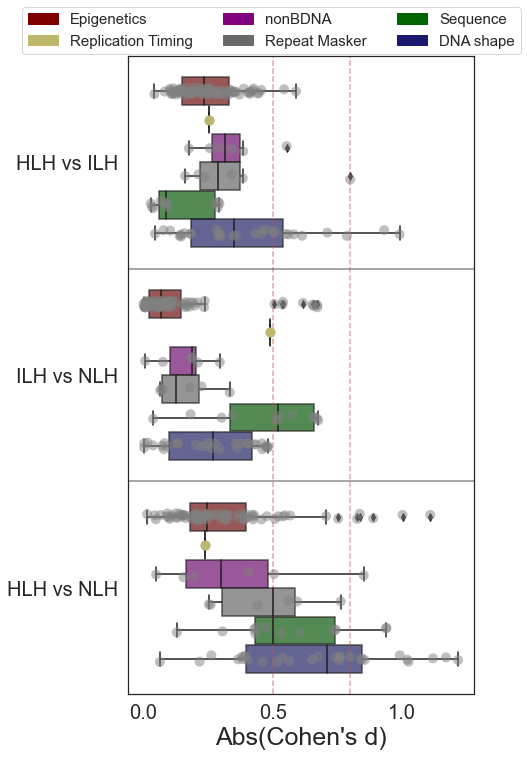

In [121]:
## Figure 3B

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
sns.set(rc={'figure.figsize':(7,10)})
sns.set_style(style='white')
    
ordering = ['HLH vs ILH', 'ILH vs NLH', 'HLH vs NLH']
hueorder = ['Epigenetics','ReplicationTiming', 'nonBDNA', 'RepeatMasker', 'SeqFeat', 'DNAShape']

sns.boxplot(ax=ax, data = homo_long_del[(homo_long_del.FeatureCat!='Homology') & (homo_long_del.FeatureCat!='n')], 
            order = ordering, boxprops=dict(alpha=0.7),
            hue = 'FeatureCat', dodge=True, hue_order = hueorder, palette = color_scheme,
            y="cohen_type", x='value')

sns.stripplot(ax = ax,size=10, 
    data = homo_long_del[(homo_long_del.FeatureCat!='Homology') & (homo_long_del.FeatureCat!='n')], 
              y="cohen_type", x='value', dodge=True, alpha = 0.5,
            order = ordering, hue = 'FeatureCat', color = 'gray', hue_order = hueorder, 
             palette=["gray"] * homo_long_del['FeatureCat'].nunique())

sns.stripplot(ax = ax,size=10, 
    data = homo_long_del[(homo_long_del.FeatureCat=='ReplicationTiming') ], 
              y="cohen_type", x='value', dodge=True, 
            order = ordering, hue = 'FeatureCat', color = 'darkkhaki', hue_order = hueorder, 
             palette=["darkkhaki"] * homo_long_del['FeatureCat'].nunique())


ax.axvline(x=0.5, color = 'r', ls='--', alpha=0.5)
ax.axvline(x=0.8, color = 'r', ls='--', alpha=0.5)
ax.axhline(y=0.5, color = 'k', ls='-', alpha = 0.5)
ax.axhline(y=1.5, color = 'k', ls='-', alpha = 0.5)

ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('', fontsize=25)
ax.tick_params(labelsize=20)
ax.set_xlabel("Abs(Cohen's d)", fontsize=25)


epi_patch = mpatches.Patch(color='maroon', label='Epigenetics')
rep_patch = mpatches.Patch(color='darkkhaki', label='Replication Timing')
nonb_patch = mpatches.Patch(color='purple', label='nonBDNA')
repeat_patch = mpatches.Patch(color='dimgray', label='Repeat Masker')
seqfeat_patch = mpatches.Patch(color='darkgreen', label='Sequence')
shape_patch = mpatches.Patch(color='midnightblue', label='DNA shape')
shape_patch = mpatches.Patch(color='midnightblue', label='DNA shape')

ax.get_legend().remove()
fig.legend(handles=[epi_patch, rep_patch, nonb_patch, 
                   repeat_patch,seqfeat_patch , shape_patch],
           fontsize=15, 
           ncol=3, loc='upper center', 
           bbox_to_anchor=(0.55, 1.05),
           borderaxespad=0
          )

plt.tight_layout()
plt.show()


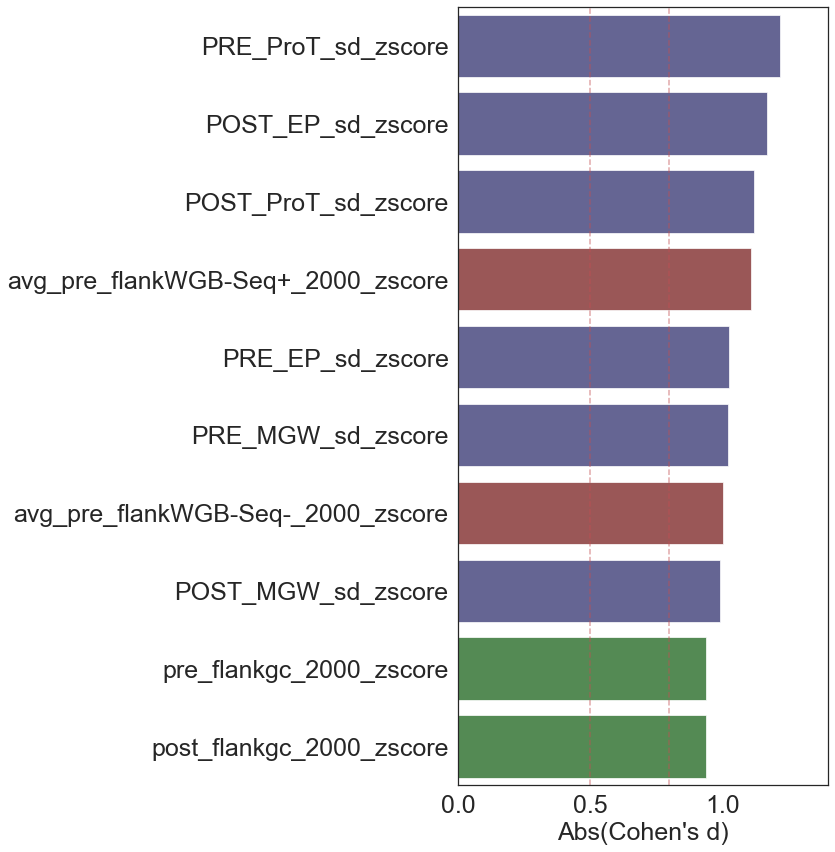

In [128]:
## Figure 3C
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
sns.set(rc={'figure.figsize':(12,12)})
sns.set_style(style='white')

sns.barplot( ax=ax, data = homo_long_del[(homo_long_del.cohen_type=='HLH vs NLH') & (homo_long_del.FeatureCat!='n')&(homo_long_del.FeatureCat!='Homology')].sort_values('value', ascending=False).head(10), 
            y="FeatureName", x="value", hue = 'FeatureCat',  palette=color_scheme , dodge=False,alpha =0.7)

ax.axvline(x=0.5, color = 'r', ls='--', alpha=0.5)
ax.axvline(x=0.8, color = 'r', ls='--', alpha=0.5)

ax.set_xlabel("Abs(Cohen's d)", fontsize=25)
ax.set_ylabel("", fontsize=25)
ax.tick_params(labelsize=25)
plt.xlim(0,1.4)
ax.get_legend().remove()
plt.tight_layout()
plt.show()

In [40]:
clust_wide_del = applycohen(big_hgsvc[(big_hgsvc.svtype == 'deletion')], 'ClusterBasedLabel')

clust_long_del = pd.melt(clust_wide_del, id_vars=['FeatureName', 'FeatureCat'], 
                     value_vars=['clusterI vs clusterII'], 
                     var_name='cohen_type', 
                     value_name='value')


/Users/nadejdaboev/opt/anaconda3/envs/blahlol/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [60]:
delscohens = homo_long_del.merge(clust_long_del, how='inner', on=['FeatureName', 'FeatureCat'])
delscohens['SVtype'] = 'DEL'

### For insertions

In [54]:
homo_wide_ins = applycohen(big_hgsvc[(big_hgsvc.svtype == 'insertion')], 'HomoBasedLabel')

homo_long_ins = pd.melt(homo_wide_ins, id_vars=['FeatureName', 'FeatureCat'], 
                     value_vars=['HLH vs ILH', 'HLH vs NLH', 'ILH vs NLH', 'HLH vs Undefined', 'NLH vs Undefined'], 
                     var_name='cohen_type', 
                     value_name='value')

/Users/nadejdaboev/opt/anaconda3/envs/blahlol/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [83]:
clust_wide_ins = applycohen(big_hgsvc[(big_hgsvc.svtype == 'insertion')], 'ClusterBasedLabel')

clust_long_ins = pd.melt(clust_wide_ins, id_vars=['FeatureName', 'FeatureCat'], 
                     value_vars=['clusterI vs clusterII'], 
                     var_name='cohen_type', 
                     value_name='value')

/Users/nadejdaboev/opt/anaconda3/envs/blahlol/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [90]:
inscohens = homo_long_ins.merge(clust_long_ins, how='inner', on=['FeatureName', 'FeatureCat'])
inscohens['SVtype'] = 'INS'

### Concatenating deletions and insertions together

In [94]:
mergedcohens = delscohens.append(inscohens, ignore_index=True)

## Visualization of the comparison between labels

We are most interested in what we expect is the MOST discriminative comparisons, therefore we will compare:

- Homology-based labels: HLH vs NLH
- Cluster-based labels: cluster I vs cluster II

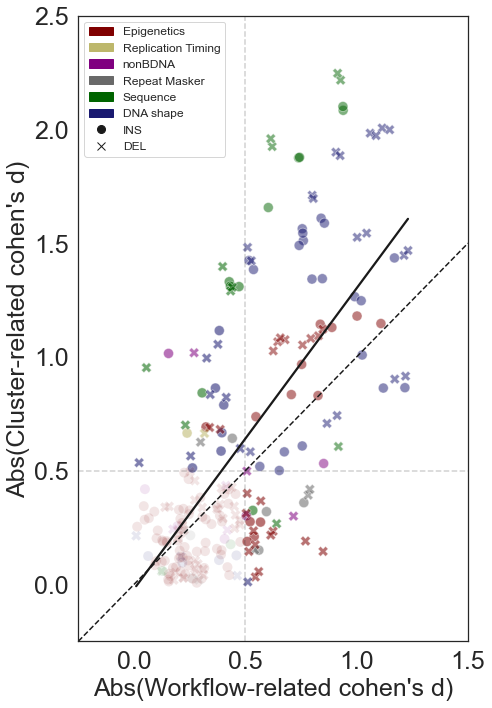

In [104]:
## Figure 4D
sns.set(rc={'figure.figsize':(7,10)})
sns.set_style(style='white')

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

sns.scatterplot(ax=ax, data = mergedcohens[(mergedcohens.FeatureCat!='Homology')&(mergedcohens.FeatureCat!='n')&(mergedcohens.cohen_type_x=='HLH vs NLH')&
                                               ((mergedcohens.value_x>0.5) | (mergedcohens.value_y>0.5))],
                x='value_x', y='value_y', alpha = 0.5 , hue='FeatureCat', palette = color_scheme, s=100,style="SVtype")

sns.scatterplot(ax=ax, data = mergedcohens[(mergedcohens.FeatureCat!='Homology')&(mergedcohens.FeatureCat!='n')&(mergedcohens.cohen_type_x=='HLH vs NLH')&
                                               ((mergedcohens.value_x<=0.5) | (mergedcohens.value_y<=0.5)) ],
                x='value_x', y='value_y', alpha = 0.1 , hue='FeatureCat', palette = color_scheme, s=100,style="SVtype")


plt.ylim(-0.25, 2.5)
plt.xlim(-0.25, 1.5)
ax.axline((0, 0), slope=1, color = 'k', ls='--')
plt.axhline(y=0.5, color='k', ls='--', alpha = 0.2)
plt.axvline(x=0.5, color='k', ls='--', alpha = 0.2)

sns.regplot(ax=ax, data = mergedcohens[(mergedcohens.FeatureCat!='Homology')&(mergedcohens.FeatureCat!='n')&(mergedcohens.cohen_type_x=='HLH vs NLH')], 
            x="value_x", y="value_y", scatter = False, ci = 0, color = 'k')

epi_patch = mpatches.Patch(color='maroon', label='Epigenetics')
rep_patch = mpatches.Patch(color='darkkhaki', label='Replication Timing')
nonb_patch = mpatches.Patch(color='purple', label='nonBDNA')
repeat_patch = mpatches.Patch(color='dimgray', label='Repeat Masker')
seqfeat_patch = mpatches.Patch(color='darkgreen', label='Sequence')
shape_patch = mpatches.Patch(color='midnightblue', label='DNA shape')


omarker = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=8, label='INS')
xmarker = mlines.Line2D([], [], color='k', marker='x', linestyle='None', markersize=8, label='DEL')


plt.legend(handles=[epi_patch, rep_patch, nonb_patch,
                   repeat_patch,seqfeat_patch , shape_patch, 
                  omarker,  xmarker], fontsize='medium')

ax.tick_params(labelsize=25)
ax.set_ylabel("Abs(Cluster-related cohen's d)", fontsize=25)
ax.set_xlabel("Abs(Workflow-related cohen's d)", fontsize=25)
plt.tight_layout()
plt.show()

In [105]:
# Additionally, here I have added the method in which the linear regression was created

xs=list(mergedcohens[(mergedcohens.FeatureCat!='Homology')&(mergedcohens.FeatureCat!='n')&(mergedcohens.cohen_type_x=='HLH vs NLH')].value_x)
ys=list(mergedcohens[(mergedcohens.FeatureCat!='Homology')&(mergedcohens.FeatureCat!='n')&(mergedcohens.cohen_type_x=='HLH vs NLH')].value_y)

x = [x for x in xs if ~np.isnan(x)]
y = [x for x in ys if ~np.isnan(x)]

slope, intercept, r, p, std_err = stats.linregress(x, y)
print(slope, intercept, r, p, std_err , r**2)

1.322713805736239 -0.020661013751295254 0.677275634464134 1.4428692987345425e-33 0.09313867451159426 0.45870228503879523
